In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot
import legacy.eigenstate_generator as eig_old

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median, mean
from matplotlib.ticker import FormatStrFormatter

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
f = open("hamiltonians/hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

small_ham_keys = []

for h in hamiltonians.keys():
    num_qubits = hamiltonians[h][1]
    if num_qubits < 10:
        small_ham_keys.append(h)

print(len(small_ham_keys))
small_ham_keys

12


['Be1_STO-3G_singlet',
 'H1-F1_STO-3G_singlet',
 'H1-Li1_STO-3G_singlet',
 'H1-O1_STO-3G_singlet',
 'H2-Be1_STO-3G_singlet',
 'H2_3-21G_singlet',
 'H2_6-31G_singlet',
 'Ne1_STO-3G_singlet',
 'H1-He1_STO-3G_singlet',
 'H3_STO-3G_singlet_1+',
 'H1-He1_3-21G_singlet_1+',
 'H3_3-21G_singlet_1+']

In [3]:
shots=5
nc_mols={}

for speciesname in small_ham_keys:
    print(speciesname)
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = c.cs_vqe(hamiltonian, terms_noncon, num_qubits)
    initial_state = mol.init_state()
    G = mol.generators()[0]
    A = mol.generators()[1]
    eig_proj = la.eigenstate_projector(A, num_qubits)
    results = {}
    nan_check = []
    for index in range(num_qubits):
        removed_index = list(range(0, index))
        removed_index.reverse()
        removed_generators = [list(G.keys())[i] for i in removed_index]
        Z_indices = [g.find('Z') for g in removed_generators]
        nc_proj = la.noncon_projector(initial_state, Z_indices, num_qubits)

        new_ham_noncon, new_ham_context = mol.move_generator(removed_generators)
        new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon)
        new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context)
        
        results[index] = {}

        results[index]['exact'] = get_ground_state(get_sparse_operator(new_ham_noncon_q, num_qubits).toarray())[0]

        expectations = []
        for r in range(shots):
            #expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
            #                                                          r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
            #                                                          Z_indices=Z_indices,rot=True)
            rand_vec = la.random_complex_vector(2**num_qubits)
            psi = la.apply_projections(rand_vec, [nc_proj, eig_proj])
            expect_noncon = la.expectation(new_ham_noncon_q, psi, num_qubits)
            #print(expect_noncon)
            expectations.append(expect_noncon)
        
        nc_value = (sum(expectations)/shots).real
        results[index]['+1eig'] = nc_value
        nan_check.append(nc_value)
    
    if all([not np.isnan(n) for n in nan_check]):
        nc_mols[speciesname] = results
        nc_mols[speciesname]['num_qubits'] = num_qubits

nc_mols

Be1_STO-3G_singlet


/mnt/c/Users/Tim/Jupyter Projects/ContextualSubspaceVQE/utils/linalg_tools.py:101: RuntimeWarning: invalid value encountered in true_divide
  psi = psi/norm


H1-F1_STO-3G_singlet


KeyboardInterrupt: 

In [ ]:
nc_mols.pop('Ne1_STO-3G_singlet')

In [ ]:
factors = la.factor_int(len(nc_mols))
print(factors)
if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))

for index, h in enumerate(nc_mols.keys()):
    grid = grid_pos[index]
    
    num_qubits = nc_mols[h]['num_qubits']
    X=range(num_qubits)
    values = list(zip(*[list(nc_mols[h][i].values()) for i in X]))
    Y1=values[0]
    Y2=values[1]
    axs[grid].set_title(str(h))
    l1 = axs[grid].plot(X, Y1, label='Exact noncontextual gs')
    l2 = axs[grid].plot(X, Y2, label='Restriction to +1-eigenspace')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 1:
            axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2) 
fig.suptitle('Noncontextual ground state energy - restriction to +1-eigenspace versus exact', fontsize=16)

In [ ]:
#fig.savefig("plots/nc_+1_restriction_versus_exact", dpi=300)

In [ ]:
proj_energy = {}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, list(range(num_qubits)))
    A = mol.A
    print(A)
    
    qubit_nums = range(1, num_qubits+1)
    gs_true = []
    gs_proj = []

    for n_q in qubit_nums:
        ham_red = mol.ham_reduced[n_q-1]
        ham_red_q = qonvert.dict_to_QubitOperator(ham_red)
        gs_red = get_ground_state(get_sparse_operator(ham_red_q, n_q).toarray())
        gs_true.append(gs_red[0])

        A_red = mol.reduce_anz_terms(A, n_q)
        eig_proj = la.eigenstate_projector(A_red, n_q)
        psi = gs_red[1]
        psi_proj = la.apply_projections(psi, [eig_proj])
        expct_proj = la.expectation(ham_red, psi_proj, n_q)
        gs_proj.append(expct_proj)
    
    proj_energy[speciesname] = {'qubit_nums':qubit_nums,
                               'gs_true':gs_true,
                               'gs_proj':gs_proj}

In [ ]:
factors = la.factor_int(len(proj_energy))

if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))


for index, speciesname in enumerate(small_ham_keys):
    grid = grid_pos[index]
    
    mol_results = proj_energy[speciesname]
    X = mol_results['qubit_nums']
    Y1 = mol_results['gs_true']
    Y2 = mol_results['gs_proj']
    
    axs[grid].get_yaxis().get_major_formatter().set_useOffset(False)
    axs[grid].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[grid].set_title(str(speciesname))
    l1 = axs[grid].plot(X, Y1, label='Exact ground state energy')
    l2 = axs[grid].plot(X, Y2, label='Energy after projection into +1-eigenspace of A')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 2:
            axs[grid].set_xlabel('Number of qubits simulated',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2)

fig.suptitle('Contextual subspace ground state energy - projection into +1-eigenspace versus exact', fontsize=16)
    

In [4]:
proj_energy = {}

for speciesname in small_ham_keys:
    num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
    hamiltonian = hamiltonians[speciesname][2] # full Hamiltonian
    terms_noncon = list(hamiltonians[speciesname][3].keys()) # noncontextual part of Hamiltonian, found by greedy DFS
    mol = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, num_electrons=2, order=list(range(num_qubits)), rot_A=True)
    A = mol.A
    #print(A)
    
    qubit_nums = range(1, num_qubits+1)
    gs_true = []
    gs_proj = []

    for n_q in qubit_nums:
        ham_red = mol.ham_reduced[n_q-1]
        ham_red_q = qonvert.dict_to_WeightedPauliOperator(ham_red)
        ham_mat = ham_red_q.to_matrix()
        gs_true.append(get_ground_state(ham_mat)[0])
        
        A_red = mol.reduce_anz_terms(A, n_q)
        eig_mat = np.matrix(la.eigenstate_projector(A_red, n_q))
        ham_proj = eig_mat*ham_mat*eig_mat
        gs_proj.append(get_ground_state(ham_proj)[0])
        print(ham_red)
        print(ham_mat)
        print(A_red)
        print(eig_mat)
        print(ham_proj)
        print('\n')
    
    proj_energy[speciesname] = {'qubit_nums':list(qubit_nums),
                                'gs_true':gs_true,
                                'gs_proj':gs_proj,
                                'diff':[a-b for a, b in zip(gs_proj, gs_true)]}

/home/tim/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1268: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


{'I': -11.719396375780056, 'Z': -2.6324841004219874, 'X': 1.5871432917924366e-08}
[[-1.43518805e+01+0.j  1.58714329e-08+0.j]
 [ 1.58714329e-08+0.j -9.08691228e+00+0.j]]
{'Z': 1.0, 'X': -2.449293597636856e-16}
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[[-14.35188048+0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j]]


{'II': -11.864256439107097, 'IZ': -2.3178868841097553, 'IX': -0.0120993378644666, 'XI': -0.043404489730760894, 'XZ': -0.0434044896687743, 'XX': 0.010281285876514864, 'YY': 0.010281285614826123, 'ZI': -0.14486006332703744, 'ZZ': 0.314597216312232, 'ZX': -0.012099353735899515}
[[-1.40124062e+01+0.j -2.41986916e-02+0.j -8.68089794e-02+0.j
   2.61688740e-10+0.j]
 [-2.41986916e-02+0.j -1.00058268e+01+0.j  2.05625715e-02+0.j
  -6.19865964e-11+0.j]
 [-8.68089794e-02+0.j  2.05625715e-02+0.j -1.43518805e+01+0.j
   1.58714329e-08+0.j]
 [ 2.61688740e-10+0.j -6.19865964e-11+0.j  1.58714329e-08+0.j
  -9.08691228e+00+0.j]]
{'IZ': 1.0, 'IX': -2.449293597636856e-16}
[[1.+0.j 0.+0.j 0.+0

{'I': -103.22030893018898, 'Z': -0.33714259864514295, 'X': 6.786022863775054e-08}
[[-1.03557452e+02+0.j  6.78602286e-08+0.j]
 [ 6.78602286e-08+0.j -1.02883166e+02+0.j]]
{'Z': 1.0}
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[[-103.55745153+0.j    0.        +0.j]
 [   0.        +0.j    0.        +0.j]]


{'II': -102.41867089645594, 'IZ': -0.49972386345342373, 'IX': 1.0053691891498406e-07, 'XI': 0.015697191677793872, 'XZ': 0.01569719319589573, 'XX': 0.007547625495617678, 'YY': -0.007547628652893033, 'ZI': 0.8016380337330529, 'ZZ': -0.1625812648082807, 'ZX': 3.2676690318866886e-08}
[[-1.02279338e+02+0.j  1.33213609e-07+0.j  3.13943849e-02+0.j
   1.50952541e-02+0.j]
 [ 1.33213609e-07+0.j -1.00954728e+02+0.j -3.15727536e-09+0.j
  -1.51810186e-09+0.j]
 [ 3.13943849e-02+0.j -3.15727536e-09+0.j -1.03557452e+02+0.j
   6.78602286e-08+0.j]
 [ 1.50952541e-02+0.j -1.51810186e-09+0.j  6.78602286e-08+0.j
  -1.02883166e+02+0.j]]
{'IZ': 1.0}
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j

{'IIIIII': -96.34048250775307, 'IIYZZY': -0.013979471154171218, 'IIIIIX': 0.01659012261482826, 'IIIIIZ': 1.7536273698397977, 'IIYZYZ': 0.0054143030603869035, 'IIIIXI': 0.031703691372968766, 'IIYZYI': 0.09413016840365966, 'IIIIXZ': 0.1612455441419316, 'IIIIYY': -0.024143967630404047, 'IIIIZI': 1.7536273698397977, 'IIIIZZ': 0.21432034653989088, 'IIYYZZ': 0.04494612232633055, 'IIIXII': 0.030527318522496575, 'IIIXIX': -0.005414296683623315, 'IIIXXI': 0.01397947449104697, 'IIYYXX': 0.039122112658123674, 'IIIXYY': 0.011969890853182256, 'IIIXZX': -0.09413013597132411, 'IIYYII': 0.04494611542791548, 'IIIXZZ': -0.0037698955758056255, 'IIIYIY': -0.005414296683623315, 'IIYXXY': -0.039122112658123674, 'IIIYYX': -0.011969890853182256, 'IIIYZY': -0.09413013597132411, 'IIIZII': 1.2506435836416259, 'IIIZIZ': 0.14867454863350857, 'IIYIYI': 0.01164916514949973, 'IIIZXZ': 0.009168768091219352, 'IIIZZI': 0.1877966636992112, 'IIYIIY': -0.013979476335219336, 'IIIZZX': -0.00916876762250916, 'IIZZZZ': -0.1780

{'IIIIIII': -81.50103080901789, 'IIYZZZY': 0.003802600531658519, 'IIIIIIX': -0.01650688035964199, 'IIIIIIZ': 14.839451698735177, 'IIIIIXX': 0.0039802291595885655, 'IIYZZYI': -0.013979471154171218, 'IIIIIXZ': -0.01659012261482826, 'IIIIIZI': 2.0541081409767417, 'IIYZZIY': 0.0032170083214209696, 'IIIIIZX': -0.0001048253111597655, 'IIIIIZZ': 0.30048077113694405, 'IIIIXIX': -0.004988548097378894, 'IIYZYZI': 0.0054143030603869035, 'IIIIXIZ': -0.031703691372968766, 'IIYZYIZ': 0.030630701275821057, 'IIIIXZI': -0.05318062271136457, 'IIIIXZX': -0.04123509546368073, 'IIYZYII': 0.12476086967948072, 'IIIIXZZ': -0.21442616685329619, 'IIIIYIY': -0.004988548097378894, 'IIIIYYI': -0.024143967630404047, 'IIIIYZY': -0.04123509546368073, 'IIIIZII': 2.0352450191190936, 'IIYZIZY': 0.0011059550886140242, 'IIIIZIX': 0.0012182019088424483, 'IIIIZIZ': 0.28161764927929583, 'IIIIZZI': 0.21432034653989088, 'IIYYZZZ': -0.04494612232633055, 'IIIXIII': 0.030527318522496575, 'IIIXIXI': -0.005414296683623315, 'IIIXXII

{'IIIIIIII': -65.32093253713555, 'IIYZZZZY': -0.0015916166446416898, 'IIIIIIIX': -0.0024026673707039227, 'IIIIIIIZ': 16.180098271882343, 'IIYZZZYZ': 0.03936502781505253, 'IIIIIIXI': 0.04087184678099299, 'IIYZZZYI': 0.04316762834671105, 'IIIIIIXZ': 0.05737872714063498, 'IIIIIIYY': -0.006360598179958599, 'IIIIIIZI': 16.180098271882343, 'IIIIIIZZ': 1.340646573147166, 'IIIIIXIX': -0.12644597509546893, 'IIIIIXXI': 0.0039802291595885655, 'IIYZZYXX': 0.005406034595604161, 'IIIIIXYY': -0.0066235248837499755, 'IIIIIXZX': -0.16768107055914974, 'IIYZZYII': -0.013979471154171218, 'IIIIIXZZ': 0.01659012261482826, 'IIIIIYIY': -0.12644597509546893, 'IIYZZXXY': -0.005406034595604161, 'IIIIIYYX': 0.0066235248837499755, 'IIIIIYZY': -0.16768107055914974, 'IIIIIZII': 2.3357257902560375, 'IIIIIZIZ': 0.28161764927929583, 'IIYZZIYI': 0.0032170083214209696, 'IIIIIZXZ': 0.0001048253111597655, 'IIIIIZZI': 0.30048077113694405, 'IIIIXIXI': -0.004988548097378894, 'IIYZYZII': 0.0054143030603869035, 'IIIIXIZZ': 0.03

{'I': -8.648992881522593, 'Z': -0.2651383463222369, 'X': 3.2809453035485825e-08}
[[-8.91413123e+00+0.j  3.28094530e-08+0.j]
 [ 3.28094530e-08+0.j -8.38385454e+00+0.j]]
{'Z': 1.0, 'X': -2.220446049250313e-16}
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[[-8.91413123+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j]]


{'II': -7.701844855666584, 'IZ': -0.6916218483425106, 'ZX': 7.552642807998334e-08, 'IX': -4.2716975023199266e-08, 'ZZ': 0.426483502020274, 'XI': 0.0, 'YY': 0.0, 'XZ': 0.0, 'XX': 0.0, 'ZI': -0.9471480258560118}
[[-8.91413123e+00+0.j  3.28094531e-08+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 3.28094531e-08+0.j -8.38385454e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -7.87280218e+00+0.j
  -1.18243403e-07+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -1.18243403e-07+0.j
  -5.63659148e+00+0.j]]
{'IZ': 1.0, 'ZX': -2.220446049250313e-16}
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j

{'IIIII': -6.3070088647057725, 'IIIIZ': -0.6901673002563812, 'ZZIZX': 0.03495319725351202, 'IIIIX': 0.03495307941328918, 'ZZIZZ': 0.42412559217130985, 'IIIXI': -0.002787484902617283, 'ZZIYY': -0.009009667142520961, 'IIIXZ': 0.016554672810779374, 'IIIXX': 0.010904255360997208, 'IIIYY': 0.01090425361028479, 'ZZIXI': 0.016554673963940975, 'IIIZI': -0.4465747896003306, 'IIIZX': -0.002455843170777309, 'ZZIIZ': -0.053512400251609596, 'IIIZZ': 0.053913679134260074, 'ZZIIX': -0.0024558545314466813, 'IIXII': 0.010904255360997208, 'IIXIX': -9.52802648059972e-10, 'ZZXZZ': 0.009009667437306768, 'IIXXZ': 0.002135874095436016, 'IIXYY': -2.2587587257964968e-10, 'ZZXXI': 0.0021358740954360044, 'IIXZX': 2.0378181860152608e-09, 'ZZXIZ': -0.019269535187666283, 'IIXZI': 0.012743506842450984, 'IIYIY': 0.007785194491376198, 'IIYYI': 6.956098214953629e-10, 'ZZYXY': -0.00657766135574706, 'IIYYX': -0.006577661355747096, 'IIYZY': -0.007785194491376198, 'IIZII': 0.4435168657351021, 'IIZIX': 0.004591716942827573,

{'IIIIIII': -6.011867275784137, 'IIYIXYX': 1.1500061661666206e-09, 'ZZYZXIY': -0.010874416784115862, 'IIIIIIZ': 0.5958863551291127, 'IIYIXXY': 9.308532583860961e-05, 'IIIIIZI': -0.48548406563440166, 'ZZIZIXZ': -0.034953175607571225, 'IIIIIXZ': -0.034953102455391336, 'ZZIZIZI': 0.2062403061833126, 'IIYIXZY': 0.0015283726900879773, 'IIIIIXI': -9.994165035837026e-09, 'ZZIZIZZ': -0.09450446372057422, 'IIIIZYY': -1.8856335161763516e-10, 'ZZIZZIX': -0.001783048244458595, 'IIYIYII': -0.03290395741989794, 'IIYIYXI': -5.792462890893424e-10, 'ZZYZYZZ': -0.0054773319948419625, 'IIIIZZX': 0.013985053870902748, 'IIYIYXZ': 1.3592978866715091e-10, 'ZZYZYZI': 0.0012853471736335217, 'IIIIIYY': -1.8856335161763516e-10, 'ZZIZIIX': -0.001783048244458595, 'IIYIXYI': 0.030761705333347874, 'IIIIIZX': 0.013985053870902748, 'IIIIZIZ': 0.20987300465121006, 'IIYIYYY': 3.10509464975542e-10, 'ZZYZYIX': 0.0029361662892750475, 'IIIIZII': -0.0908717615562679, 'IIIIZXI': 1.3047937118016264e-08, 'ZZIZZZZ': 0.1233808222

{'IIIIIIII': -5.001425458221718, 'IIIIIYZY': 0.0005602367691690761, 'IIIIIIIZ': 1.0104418175624195, 'IIYIXYXZ': -1.1798614799546743e-09, 'ZZYZXIYZ': 0.011156727553312918, 'IIYIXYXI': -2.985531378805364e-11, 'ZZYZXIYI': 0.0002823107691970561, 'IIYIXIXY': -1.9558577348473536e-10, 'ZZYZXYYY': 0.0018494520120760226, 'IIIIIIZI': 1.0104418175624192, 'IIIIIIZZ': 0.41455546243330654, 'IIIIIXIX': 3.073237824828464e-09, 'ZZIZIZZX': 0.02906042590649232, 'IIYIXXYI': 9.308532583860961e-05, 'IIYIXZYX': 0.0020610093726644778, 'IIIIIXZX': 0.0005602383634403927, 'ZZIZIZIX': 0.01507537197634273, 'IIIIIZII': -0.3969060530882687, 'ZZIZIXZI': -0.034953166240148346, 'IIIIIIZX': -0.02906042590649248, 'IIYIXYXX': 2.1795867623479548e-10, 'ZZYZXIYX': -0.0020610093726644665, 'IIIIIIIX': -0.015075372035589736, 'IIIIIXZZ': 0.03495311206538589, 'ZZIZIZIZ': -0.1153685446270452, 'IIIIIXZI': 9.609994558308346e-09, 'ZZIZIZII': 0.0908717615562674, 'IIYIXZYZ': -0.0015283726900879773, 'IIIIIXIZ': 9.994165035837026e-09, 'Z

{'I': -77.37219376388003, 'Z': -0.3961915594077816, 'X': -2.917072347563554e-08}
[[-7.77683853e+01+0.j -2.91707235e-08+0.j]
 [-2.91707235e-08+0.j -7.69760022e+01+0.j]]
{'Z': 1.0}
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[[-77.76838532+0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j]]


{'II': -76.84119702940102, 'IZ': 0.19534228901441536, 'IX': -0.508284587491894, 'XI': 0.0, 'XZ': 0.0, 'XX': 0.0, 'YY': 0.0, 'ZI': -0.5309967344790143, 'ZZ': -0.5915338484221969, 'ZX': 0.5082845583211706}
[[-7.77683853e+01+0.j -2.91707234e-08+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-2.91707234e-08+0.j -7.69760022e+01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -7.55233242e+01+0.j
  -1.01656915e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -1.01656915e+00+0.j
  -7.70970764e+01+0.j]]
{'IZ': 1.0}
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[-77.76838532+0.j   0.    

{'IIIIII': -74.06862011926752, 'IIYZZY': -0.02226193151149964, 'IIIIIX': -0.006197796927534921, 'IIIIIZ': 1.1135319596992876, 'IIYZYZ': -0.013653406686962515, 'IIIIXI': -0.023899872017606277, 'IIYZYI': -0.04082521359210975, 'IIIIXZ': -0.14942081523597048, 'IIIIYY': -0.02712209450265796, 'IIIIZI': 1.113531959699288, 'IIIIZZ': 0.18145432223994393, 'IIYYZZ': 0.019046950019389795, 'IIIXII': -0.039294458630046644, 'IIIXIX': -0.010542215742313203, 'IIIXXI': 0.008725502507008364, 'IIYYXX': 0.028241707118583703, 'IIIXYY': 0.023493731237538347, 'IIIXZX': -0.09316952707476128, 'IIYYII': 0.036187453299374193, 'IIIXZZ': -0.02602683874385948, 'IIIYIY': -0.010542215742313203, 'IIYXXY': -0.028241707118583703, 'IIIYYX': -0.023493731237538347, 'IIIYZY': -0.09316952707476128, 'IIIZII': 0.7091139891009077, 'IIIZIZ': 0.11894505319471695, 'IIYIYI': 0.00048378982473318234, 'IIIZXZ': -0.0023085760301702458, 'IIIZZI': 0.15481020969928455, 'IIYIIY': -0.004525993920331298, 'IIIZZX': 0.0075307193500205915, 'IIZZ

{'IIIIIII': -62.842162626608584, 'IIYZZZY': -0.0079752258276575, 'IIIIIIX': 0.012845932770185177, 'IIIIIIZ': 11.226457492658938, 'IIIIIXX': 0.005132971139812861, 'IIYZZYI': -0.02226193151149964, 'IIIIIXZ': 0.006197796927534921, 'IIIIIZI': 1.3693653645103763, 'IIYZZIY': 0.0016407608928069345, 'IIIIIZX': 0.002127321436893694, 'IIIIIZZ': 0.2558334048110885, 'IIIIXIX': -0.0041091893697961365, 'IIYZYZI': -0.013653406686962515, 'IIIIXIZ': 0.023899872017606277, 'IIYZYIZ': -0.009567284079637736, 'IIIIXZI': 0.05985221186983394, 'IIIIXZX': -0.02925616335416209, 'IIYZYII': -0.050392497671747485, 'IIIIXZZ': 0.20927302710580442, 'IIIIYIY': -0.0041091893697961365, 'IIIIYYI': -0.02712209450265796, 'IIIIYZY': -0.02925616335416209, 'IIIIZII': 1.3537025733202057, 'IIYZIZY': 0.0013032166689951462, 'IIIIZIX': -0.00015016282938948018, 'IIIIZIZ': 0.24017061362091774, 'IIIIZZI': 0.18145432223994393, 'IIYYZZZ': -0.019046950019389795, 'IIIXIII': -0.039294458630046644, 'IIIXIXI': -0.010542215742313203, 'IIIXXII

{'IIIIIIII': -50.42916030385869, 'IIYZZZZY': 0.00044808048463248215, 'IIIIIIIX': 0.0035319426748919866, 'IIIIIIIZ': 12.4130023227499, 'IIYZZZYZ': -0.0004761878939495527, 'IIIIIIXI': -0.05794722940794079, 'IIYZZZYI': -0.008451413721607053, 'IIIIIIXZ': -0.07079316217812597, 'IIIIIIYY': -0.007039880948512146, 'IIIIIIZI': 12.413002322749898, 'IIIIIIZZ': 1.186544830090961, 'IIIIIXIX': -0.10879978378227068, 'IIIIIXXI': 0.005132971139812861, 'IIYZZYXX': -0.0004472549559723102, 'IIIIIXYY': 0.008417627152020891, 'IIIIIXZX': -0.13805594713643282, 'IIYZZYII': -0.02226193151149964, 'IIIIIXZZ': -0.006197796927534921, 'IIIIIYIY': -0.10879978378227068, 'IIYZZXXY': 0.0004472549559723102, 'IIIIIYYX': -0.008417627152020891, 'IIIIIYZY': -0.13805594713643282, 'IIIIIZII': 1.6095359781312941, 'IIIIIZIZ': 0.24017061362091774, 'IIYZZIYI': 0.0016407608928069345, 'IIIIIZXZ': -0.002127321436893694, 'IIIIIZZI': 0.2558334048110885, 'IIIIXIXI': -0.0041091893697961365, 'IIYZYZII': -0.013653406686962515, 'IIIIXIZZ': 

{'I': -16.321920975922552, 'X': 4.694046966818429e-08, 'Z': -2.724772415756721}
[[-1.90466934e+01+0.j  4.69404697e-08+0.j]
 [ 4.69404697e-08+0.j -1.35971486e+01+0.j]]
{'Z': 1.0}
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[[-19.04669339+0.j   0.        +0.j]
 [  0.        +0.j   0.        +0.j]]


{'II': -14.551893148035784, 'IX': 3.138600817726425e-08, 'IZ': -1.8218763026370433, 'XI': 0.0, 'ZI': -1.7700278278867771, 'ZX': 1.5554461491210006e-08, 'ZZ': -0.9028961131196771}
[[-1.90466934e+01+0.j  4.69404697e-08+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 4.69404697e-08+0.j -1.35971486e+01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -1.37008455e+01+0.j
   1.58315467e-08+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  1.58315467e-08+0.j
  -1.18628851e+01+0.j]]
{'IZ': 1.0}
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[-19.04669339+0.j   0.        +0.j   0.        +0.j 

{'IIIIII': -13.78380550913242, 'IIIIIX': 2.259348169381991e-08, 'IIIIIZ': -1.3114929639284845, 'IIIYYI': -0.001977027337419966, 'IIIIZI': 0.24117798322840048, 'IIIIZX': -3.0603349224812225e-09, 'IIIIZZ': 0.1776444981864806, 'IIIXZI': 0.024087825635837196, 'IIIZXI': -0.020804615130560797, 'IIIIXI': 0.020804615130560797, 'IIIZZI': -0.19831240524003202, 'IIIZZX': 3.798793059743942e-09, 'IIIZZZ': -0.22051007617484908, 'IIIXXI': 0.021103546114210933, 'IIIXXX': -0.004425473353438296, 'IIIXXZ': 0.04091026198049619, 'IIIXYY': -0.004425472648664972, 'IIIZII': -0.23372716139724525, 'IYYIII': -0.025522404317065872, 'IYYXZI': 0.003459006871821896, 'IYYZXI': 0.0037664248486789656, 'IYYIXI': -0.0037664248486789656, 'IYXZYI': 0.0037664248486789656, 'IYXYII': -0.003459006871821896, 'IYXIYI': -0.0037664248486789656, 'IIZIII': -0.7474078325256062, 'IIZIIX': 7.82582723392869e-09, 'IIZIIZ': -0.45426895653494437, 'IIZIZI': -0.17636820359738986, 'IIZZZI': 0.17636820359738986, 'IIZXXI': -0.024984977102548454

{'IIIIIIII': -14.11155839475363, 'IIIIIIZX': 0.017778488402519194, 'IIIIIIIZ': -1.6500543202932776, 'IIIIIIZZ': -0.11421086018839194, 'IIIIIIIX': 0.01777851486095401, 'IIIIIIZI': -0.11669843437820623, 'IIIIYIYX': -0.0009000465964271142, 'IIIIYIXY': 0.0009000462654706006, 'IIIIYIYI': 0.019211166525740543, 'IIIIYIYZ': 0.019211166510235175, 'IIIIIZZI': 0.1073295085273431, 'IIIIIZIX': 0.0017481205656726124, 'IIIIIZZZ': 0.12357978570286367, 'IIIIIZIZ': -0.10077071047353747, 'IIIIIZZX': 0.0017481167007194882, 'IIIIIZII': -0.10372494271566067, 'IIIYYZII': 0.001977027337419966, 'IIIYZYXX': -0.00014856692817355504, 'IIIYZYXZ': 0.002738209690202524, 'IIIYXYZI': 0.01801841299638744, 'IIIIZIZI': -0.13704604888281358, 'IIIIZIIX': -0.004449783923767065, 'IIIIZIZZ': -0.1148131158436648, 'IIIIZIIZ': 0.06283138234281581, 'IIIIZIZX': -0.004449780863432143, 'IIIIZXZI': 0.011524202447891041, 'IIIIZZII': -0.1041319343455869, 'IIIIXXXZ': 0.012349069573990106, 'IIIIXXXX': 0.0010843904217545178, 'IIIXXIXX': -

{'IIIIIIIII': -11.893640687855415, 'IIIIIIZIX': 0.05047982796347588, 'IIIIIIIIZ': -2.217917707767845, 'IIIIYIXYX': 0.005675199558538011, 'IIIIIIIZI': 2.2179177068982137, 'IIIIIIZZX': 0.03270133956095669, 'IIIIIIIZZ': -0.5678633874745677, 'IIIIYIYXZ': 0.0009000465964271142, 'IIIIIIZIZ': 0.009368924981231149, 'IIIIIIIIX': 0.05047986633360912, 'IIIIIIZZZ': 0.12357978516962309, 'IIIIIIIZX': 0.032701351472655106, 'IIIIIIZII': -0.11669843437820623, 'IIIIIZIXI': -0.0017481184367266682, 'IIIIIZZYY': -0.006881351354772961, 'IIIIIZIYY': -0.006881351354772961, 'IIIIIZIXX': -5.633559295188356e-10, 'IIIIIZZXZ': -0.03270134934370916, 'IIIIIZZXI': 0.050479866172207837, 'IIIIYIYZX': 0.0009000465964271142, 'IIIIIIZXI': 0.0017481184367266682, 'IIIIIIIYY': 0.006881351354772961, 'IIIIYIXZY': 3.3095651352982026e-10, 'IIIIYIYZI': -0.019211166510235172, 'IIIIIIZYY': 0.006881351354772961, 'IIIIYIYIZ': 0.019211166510235175, 'IIIIIIZXX': 5.633559295188356e-10, 'IIIIIIIXZ': 0.03270134934370916, 'IIIIIIIXI': -0.0

{'I': -1.3106483906898856, 'X': -9.173147214047717e-09, 'Z': 0.5324528809728273}
[[-7.78195510e-01+0.j -9.17314721e-09+0.j]
 [-9.17314721e-09+0.j -1.84310127e+00+0.j]]
{'Z': -1.0}
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[ 0.        +0.j  0.        +0.j]
 [ 0.        +0.j -1.84310127+0.j]]


{'II': 1.6263445053789378, 'IX': 1.105827231173695e-08, 'ZZ': -0.6418225990711778, 'IZ': 1.1742754800440052, 'ZX': -2.0231419539662454e-08, 'XX': 0.0, 'XI': 0.0, 'YY': 0.0, 'XZ': 0.0, 'ZI': -2.936992896068823}
[[-7.78195510e-01+0.j -9.17314723e-09+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-9.17314723e-09+0.j -1.84310127e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  6.37943548e+00+0.j
   3.12896919e-08+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  3.12896919e-08+0.j
   2.74723932e+00+0.j]]
{'IZ': -1.0}
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[ 0.        +0.j  0.  

{'I': -1.3789587486531962, 'X': -8.14576199548167e-09, 'Z': 0.47280909168603524}
[[-9.06149657e-01+0.j -8.14576200e-09+0.j]
 [-8.14576200e-09+0.j -1.85176784e+00+0.j]]
{'Z': -1.0}
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[ 0.        +0.j  0.        +0.j]
 [ 0.        +0.j -1.85176784+0.j]]


{'II': 1.3212868616207123, 'IX': 1.0336765998708586e-08, 'ZZ': -0.5996274274132103, 'IZ': 1.0724365190992455, 'ZX': -1.8482527994190256e-08, 'XX': 0.0, 'XI': 0.0, 'YY': 0.0, 'XZ': 0.0, 'ZI': -2.7002456102739085}
[[-9.06149657e-01+0.j -8.14576200e-09+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-8.14576200e-09+0.j -1.85176784e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  5.69359642e+00+0.j
   2.88192940e-08+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  2.88192940e-08+0.j
   2.34946853e+00+0.j]]
{'IZ': -1.0}
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
[[ 0.        +0.j  0.

{'I': -108.9809897477193, 'Z': -17.6235352490855, 'X': 1.7086113117681379e-06}
[[-1.26604525e+02+0.j  1.70861131e-06+0.j]
 [ 1.70861131e-06+0.j -9.13574545e+01+0.j]]
{'Z': 1.0}
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
[[-126.604525+0.j    0.      +0.j]
 [   0.      +0.j    0.      +0.j]]


{'II': -104.66237204635337, 'IZ': -16.787147230585177, 'IX': -0.05591178114590269, 'XI': 0.0, 'XZ': 0.0, 'XX': 0.0, 'YY': 0.0, 'ZI': 4.318617701365936, 'ZZ': 0.8363880185003238, 'ZX': -0.05591348975721447}
[[-1.16294514e+02+0.j -1.11825271e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-1.11825271e-01+0.j -8.43929951e+01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -1.26604525e+02+0.j
   1.70861131e-06+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  1.70861131e-06+0.j
  -9.13574545e+01+0.j]]
{'IZ': 1.0}
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[-116.29451356+0.j    0.      

{'I': -2.18074074863124, 'Z': 0.7224721700854841, 'X': 1.3612837579390913e-08}
[[-1.45826858e+00+0.j  1.36128376e-08+0.j]
 [ 1.36128376e-08+0.j -2.90321292e+00+0.j]]
{'Z': -1.0}
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[ 0.        +0.j  0.        +0.j]
 [ 0.        +0.j -2.90321292+0.j]]


{'II': -1.438528639099044, 'ZZ': -0.01919944406113084, 'ZX': -0.07733163434390385, 'XI': -0.07195737217001562, 'XX': 0.051042862665487465, 'XZ': 0.06305338570516404, 'YY': -0.03745984341074934, 'IX': 0.07733164795674143, 'IZ': 0.7416716141466151, 'ZI': -0.7422121095321959}
[[-1.45826858e+00+0.j  1.36128376e-08+0.j -8.90398646e-03+0.j
   8.85027061e-02+0.j]
 [ 1.36128376e-08+0.j -2.90321292e+00+0.j  1.35830193e-02+0.j
  -1.35010758e-01+0.j]
 [-8.90398646e-03+0.j  1.35830193e-02+0.j  6.45545286e-02+0.j
   1.54663282e-01+0.j]
 [ 8.85027061e-02+0.j -1.35010758e-01+0.j  1.54663282e-01+0.j
  -1.45718759e+00+0.j]]
{'IZ': -1.0}
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0

{'IIIII': -0.3652245346087712, 'YIXIY': -0.1045594833638649, 'IIIIZ': -0.1107896193025639, 'YXXIY': 0.02377908158109533, 'IXIIZ': -0.04054889466637289, 'IZIZI': -0.2428734478156842, 'IZZXZ': -0.10962235290078101, 'YZXZY': 0.013112938412863522, 'YZYXX': 0.0026544519545117513, 'IZIZZ': 0.13658621256812872, 'IZZXI': 0.03536040635290428, 'IIZIX': 0.00845677045620999, 'IIIYY': 0.005080544538672475, 'YIYII': -0.012390893251231118, 'YIXYZ': 0.009256283887903415, 'YZYZZ': -0.028516697782938718, 'IZZZX': 0.034393422210320976, 'YZYZI': 0.06178578562046614, 'IIIIX': 0.00845677045620999, 'IIZYY': 0.005080544538672475, 'YYXZI': -0.015022576965870081, 'IZIZX': 0.034393422210320976, 'IIZIZ': 0.38118159857162176, 'YIYIX': -0.016424051666757727, 'IIZII': 0.0017219308390574728, 'IXZIZ': -0.015597928696236302, 'IZZZZ': -0.13734855644921462, 'IZIXI': -0.0269580111997228, 'IXIXI': 0.013866101658714228, 'IXZZZ': 0.015597927993404204, 'IIIXI': 0.026957997068121763, 'IIZZZ': -0.14145232906501498, 'IYIYI': 0.0

{'I': -2.5352076929768144, 'X': -3.859836524011673e-08, 'Z': -0.6099269282717008}
[[-3.14513462e+00+0.j -3.85983652e-08+0.j]
 [-3.85983652e-08+0.j -1.92528076e+00+0.j]]
{'Z': 0.9999999999999999, 'X': 2.220446049250313e-16}
[[1.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 5.55111512e-17+0.j]]
[[-3.14513462e+00+0.j -2.14263969e-24+0.j]
 [-2.14263969e-24+0.j -5.93272940e-33+0.j]]


{'II': 0.7197501707783388, 'IX': 0.17801537874554244, 'IZ': -0.46936929104278435, 'XI': 0.0, 'ZI': -3.2549578637551537, 'ZX': -0.1780154173439077, 'ZZ': -0.14055763722891648}
[[-3.14513462e+00+0.j -3.85983653e-08+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-3.85983653e-08+0.j -1.92528076e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  3.64589638e+00+0.j
   3.56030796e-01+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  3.56030796e-01+0.j
   4.30351969e+00+0.j]]
{'IZ': 0.9999999999999999, 'IX': 2.220446049250313e-16}
[[1.00000000e+00+0.j 0.00000000e+

  -5.22893988e-35+0.j  3.39250930e-24+0.j  5.14238103e-33+0.j]]


{'IIIIII': 1.7366818425169288, 'YYXIII': -0.020281467760967373, 'IIZZZX': 0.13759827741644717, 'IIZIZZ': 0.391019701618626, 'IIIIXX': -0.0023698904180427523, 'IIIZXZ': 0.009256523922062006, 'YYYZYI': -0.042886958810401325, 'IIZZXI': 0.009256523777864066, 'IIIIZI': -0.5349048373683005, 'IIZZIX': -0.01747134261527825, 'IIZIIZ': -0.09794786184832452, 'IYZYIZ': -0.021086604314737883, 'IYIXYZ': -0.007631440498959903, 'IYZYYY': -0.001969557763085102, 'IYZXYI': -0.007631440379120559, 'IYZYZZ': 0.11348993498613034, 'IYIXIY': -0.016368836195645227, 'IYIYII': 0.03960546735214189, 'YIXYXZ': 0.023477722284290407, 'YIYXZZ': 0.010164580800188018, 'IIIZII': -0.5124050258334367, 'IIZIZX': -0.013624376441343072, 'IIZZZZ': -0.12044767361726035, 'IIIZXX': 0.0023698963508152, 'IIIIXZ': -0.009256513159376754, 'IIZIXI': -0.009256513015178451, 'IIIZZI': 0.11012714190268934, 'YYXZZZ': -2.3785381647000427e-09, 'YYXIZX': -3.696597103396342e-09, '

{'IIIIIII': 2.1553845352676197, 'YYXIIZI': 0.020281467760967373, 'IIZZZIX': 0.15122265613390645, 'IIZIZZZ': -0.5114673792197224, 'IIIIIZI': 0.4187026927506911, 'IIZZZZX': 0.013624378717459269, 'IIZIZIZ': -0.1204476776010964, 'IIIIXIX': -0.002369898063751966, 'IIIZXZZ': -0.009256513311565287, 'IIIIXZX': -7.645709213981476e-09, 'IIIZXIZ': 1.0610496719976549e-08, 'YYYZYII': -0.042886958810401325, 'IIZZXII': 0.00925651316736688, 'IIZZXZI': -1.0610497185185974e-08, 'IIIIZII': -0.6282432744727833, 'IIZZIIX': -0.01747134261527825, 'IIZIIZZ': 0.09794786184832452, 'IIIIZZI': -0.09333843710448277, 'IYZYIIZ': -0.021086604314737883, 'IYIXYZZ': 0.007631440498959903, 'IYZYYZY': 0.001969557763085102, 'IYZXYII': -0.007631440379120559, 'IYZYZZZ': 0.013763735525063266, 'IYZYZIZ': 0.12725367051119363, 'IYIXIIY': -0.016368836195645227, 'IYIYIZI': -0.03960546735214189, 'YIXYXZZ': -0.023477722284290407, 'YIYXZIZ': 0.010164580800188018, 'IIIZIZI': 0.5973491069164563, 'IIZIZZX': 0.013624376441343072, 'IIZZZIZ

{'IIIIIIII': 2.868571887203263, 'YYXIIZII': 0.020281467760967373, 'IIZZZIZX': 0.16869399817863193, 'IIZIZZZZ': -0.6094152413737619, 'IIIIIIZI': -0.7131873519356433, 'IIZZZIIX': -0.017471342044725474, 'IIZIZZIZ': 0.09794786215403947, 'IYIYZIXZ': 0.0076314425813250476, 'IYZXIIXY': -0.0019695583127016295, 'IYZYIZXI': -0.007631442461485671, 'YIXYZIXZ': 0.005525687180504238, 'IIIIIZZI': 0.6906875367226581, 'IIZZZZIX': 0.013624378717459269, 'IIZIZIIZ': -0.1204476776010964, 'YYYZZYYY': -1.9422991834922902e-09, 'YYYIZXYI': 1.4704620043278236e-09, 'IIIIIZII': -0.27198484397196704, 'IIIIXIZX': -0.002369898063751966, 'IIIZXZZZ': -0.009256513311565287, 'IYZXXZYZ': 0.0024409580841822337, 'IIIIXZZX': 1.1930419012016087e-09, 'IIIZXIZZ': -2.2208319469942588e-09, 'IIIIXZIX': -8.838751115183084e-09, 'IIIZXIIZ': 1.2831328666970809e-08, 'YYYZYIZI': -0.042886958810401325, 'YYYZXXYZ': 0.007658879255542538, 'IIZZXIII': 0.00925651316736688, 'IYZXYZXZ': -0.0024409580841822337, 'IIZZXZII': 2.220832019585867e-09

{'IIIIIIIII': 2.4308355167283833, 'YYXIIZIII': 0.020281467760967373, 'IIZZZIZZX': -0.13231905857362744, 'IIZIZZZZZ': 0.4377363624238185, 'IYIYZZYXY': 1.6812630796290408e-09, 'IYIXZIYXI': -2.240944311431338e-09, 'IYZXIZXYZ': 1.0895677934937843e-09, 'YIYXIIXXZ': 0.026033316244541305, 'IIIIIIIZI': -0.43773637047487973, 'IIZZZIZIX': 0.036374939605004486, 'IIZIZZZIZ': -0.1716788789499434, 'IIIIIIZZI': 0.5927396735055607, 'IIZZZIIIX': -0.017471342044725474, 'IIZIZZIIZ': 0.09794786215403947, 'IYZXIZYXZ': 0.008257038936646087, 'IIIIIIZII': -0.12044767843008267, 'IYIYZIXIZ': 0.0076314425813250476, 'IIZZZZIXI': -0.022499815212985278, 'IYZXIIXIY': -0.0019695583127016295, 'IYZYIZXII': -0.007631442461485671, 'IIIIIZIXX': 0.003846963327266219, 'IIIZIIIXZ': 0.022499815447056957, 'IIZZZIZXI': 0.022499815212985278, 'YIXYZIXIZ': 0.005525687180504238, 'IIIIIIZXX': -0.003846963327266219, 'IIIZIZZXZ': -0.022499815447056957, 'IIIIIZZZI': -0.5927396735055607, 'IIZZZZIIX': 0.013624378717459269, 'IIZIZIIIZ': -

In [ ]:
proj_energy

Text(0.5, 0.98, 'Contextual subspace ground state energy - projection into +1-eigenspace versus exact')

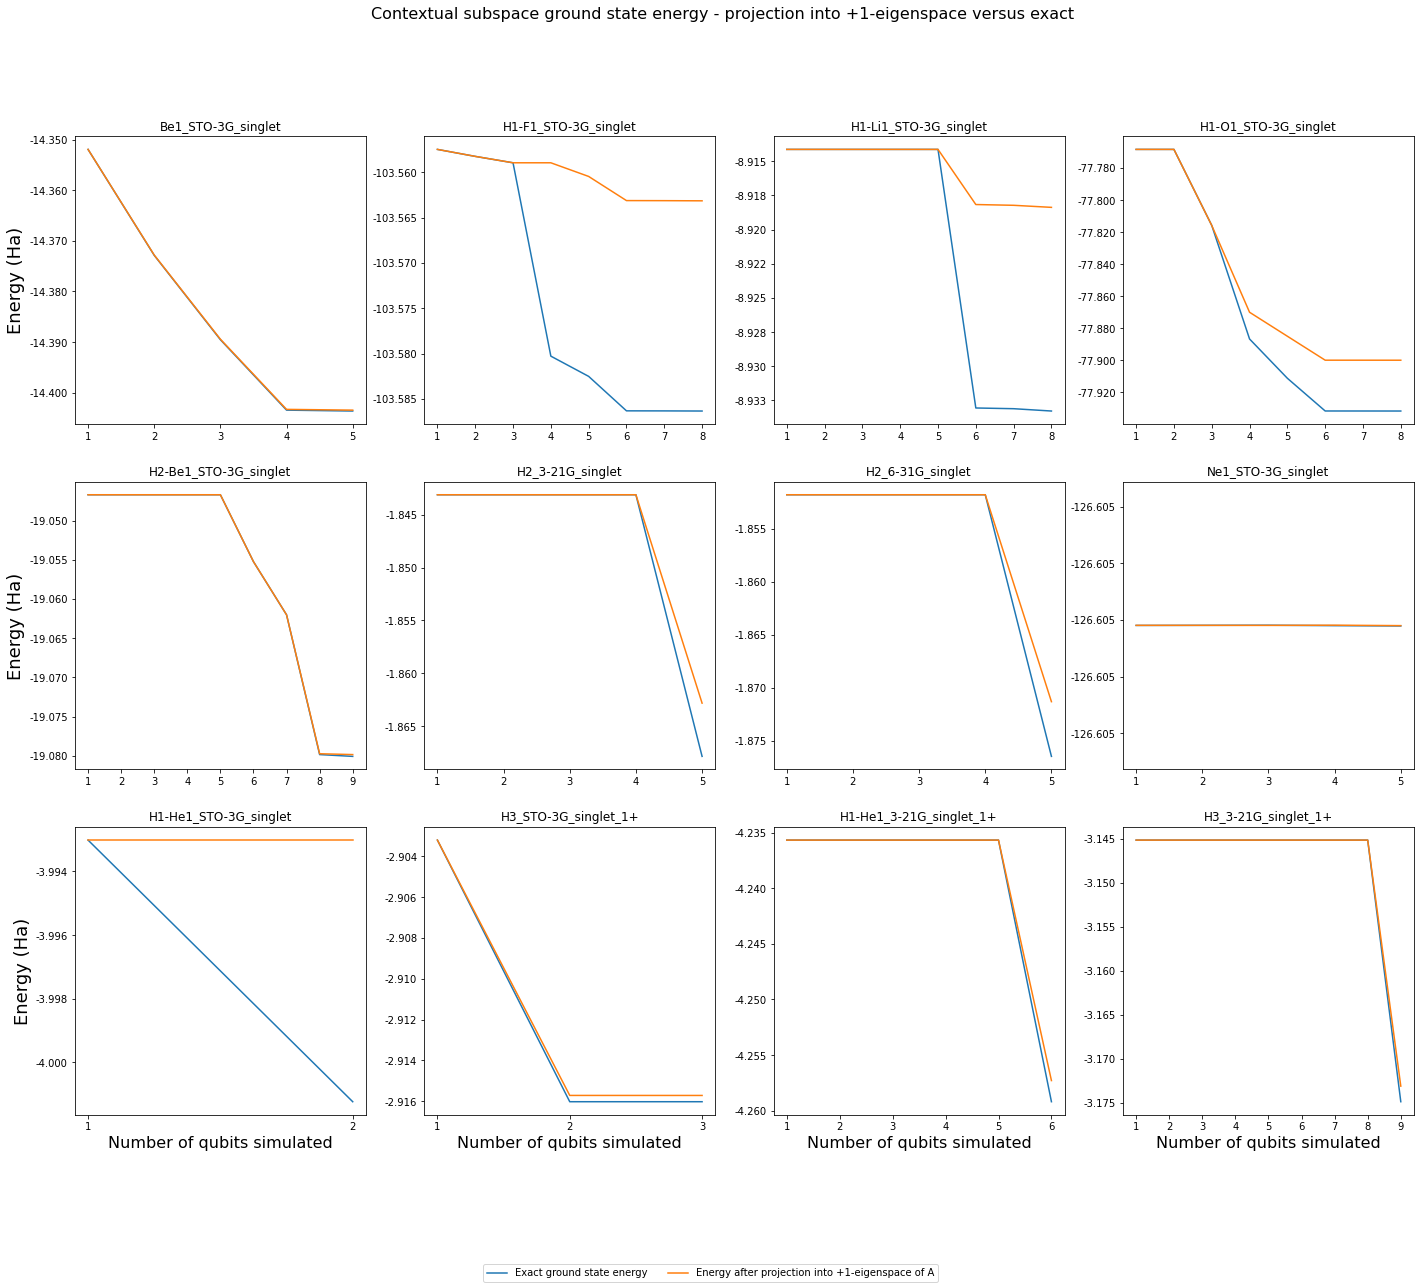

In [5]:
factors = la.factor_int(len(proj_energy))

if factors[0] == 1:
    grid_pos = range(factors[1])
else:
    grid_pos = list(itertools.product(range(factors[0]), range(factors[1])))

fig, axs = plt.subplots(nrows = factors[0], ncols = factors[1], figsize = (6*factors[1],6*factors[0]))


for index, speciesname in enumerate(small_ham_keys):
    grid = grid_pos[index]
    
    mol_results = proj_energy[speciesname]
    X = mol_results['qubit_nums']
    Y1 = mol_results['gs_true']
    Y2 = mol_results['gs_proj']
    
    axs[grid].get_yaxis().get_major_formatter().set_useOffset(False)
    axs[grid].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axs[grid].set_title(str(speciesname))
    l1 = axs[grid].plot(X, Y1, label='Exact ground state energy')
    l2 = axs[grid].plot(X, Y2, label='Energy after projection into +1-eigenspace of A')
    axs[grid].set_xticks(X)
    
    if factors[0] != 1:
        if grid[0] == 2:
            axs[grid].set_xlabel('Number of qubits simulated',fontsize=16)
        if grid[1] == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    else:
        axs[grid].set_xlabel('Number of generators removed',fontsize=16)
        if grid == 0:
            axs[grid].set_ylabel('Energy (Ha)',fontsize=18)

handles, labels = axs[grid].get_legend_handles_labels()
fig.legend(handles, 
           labels, 
           loc="lower center", 
           borderaxespad=0.1,
           ncol=2)

fig.suptitle('Contextual subspace ground state energy - projection into +1-eigenspace versus exact', fontsize=16)
    

In [ ]:
fig.savefig("plots/noncontextual_gs_exact_versus_+1_restriction", dpi=300)

In [ ]:
H1-He1_STO-3G_singlet